In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 21c

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dropout (after MaxPool Layer)
- Dataset From CSV File

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
    
%matplotlib inline

2024-07-25 18:08:28.282313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 18:08:28.295482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 18:08:28.299179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 18:08:28.309307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 18:08:29.196044: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'dropout_after_MaxPool'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 50 # number of cycles to run
BATCH_SIZE = 32 # inline of Traing Rows being 60000
PATIENCE = 5 # Patience for early stopping

# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1721911109.828706   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721911109.870040   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721911109.874560   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [5]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [6]:
train_filename = os.path.join(inpDir, subDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, subDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Converting to Datasets

In [9]:
# Each row need to be seperated in features and labels
def split_feature_label(row):

    '''
    Args:
        row: tensor of 785 values
    returns:
        feature : np.ndarray of shape (28 x 28, 1)
        label: integer
    '''
    
    feature = tf.reshape(row[1:], [28, 28, 1])
    
    label = row[0]
    
    return feature, label

In [10]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

I0000 00:00:1721911112.150771   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721911112.155806   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721911112.159817   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721911112.323697   22933 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


2024-07-25 18:08:33.664149: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376800000 exceeds 10% of free system memory.


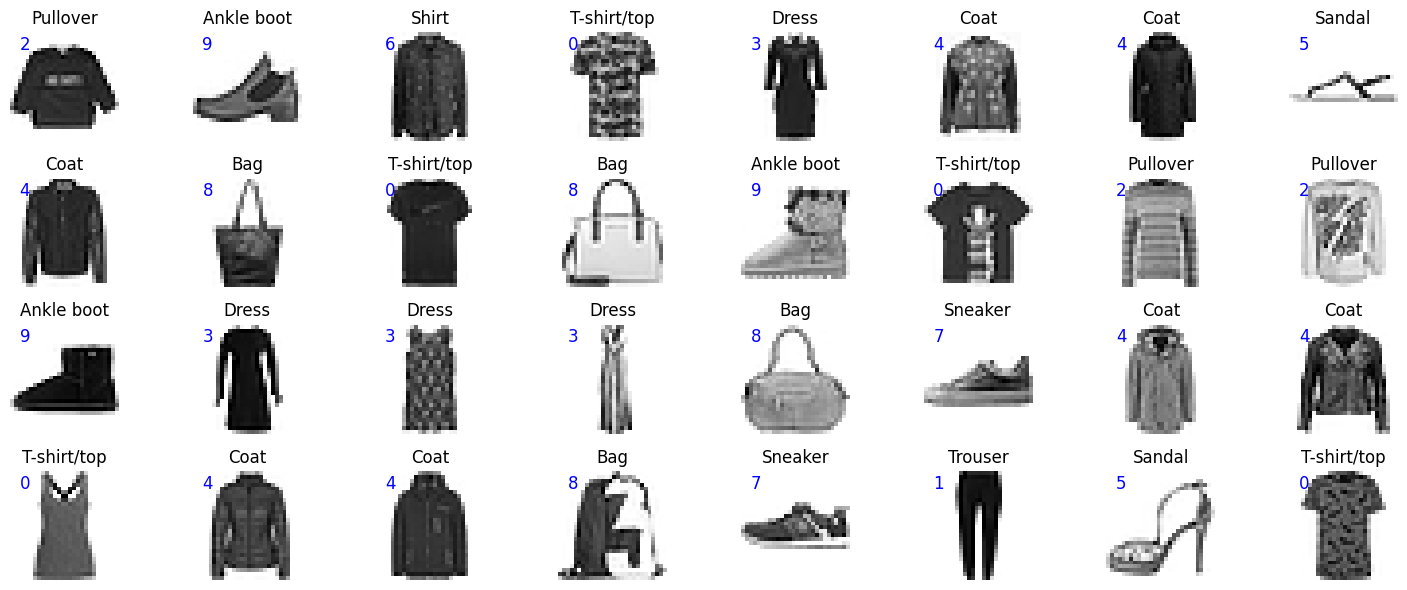

2024-07-25 18:08:34.838002: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

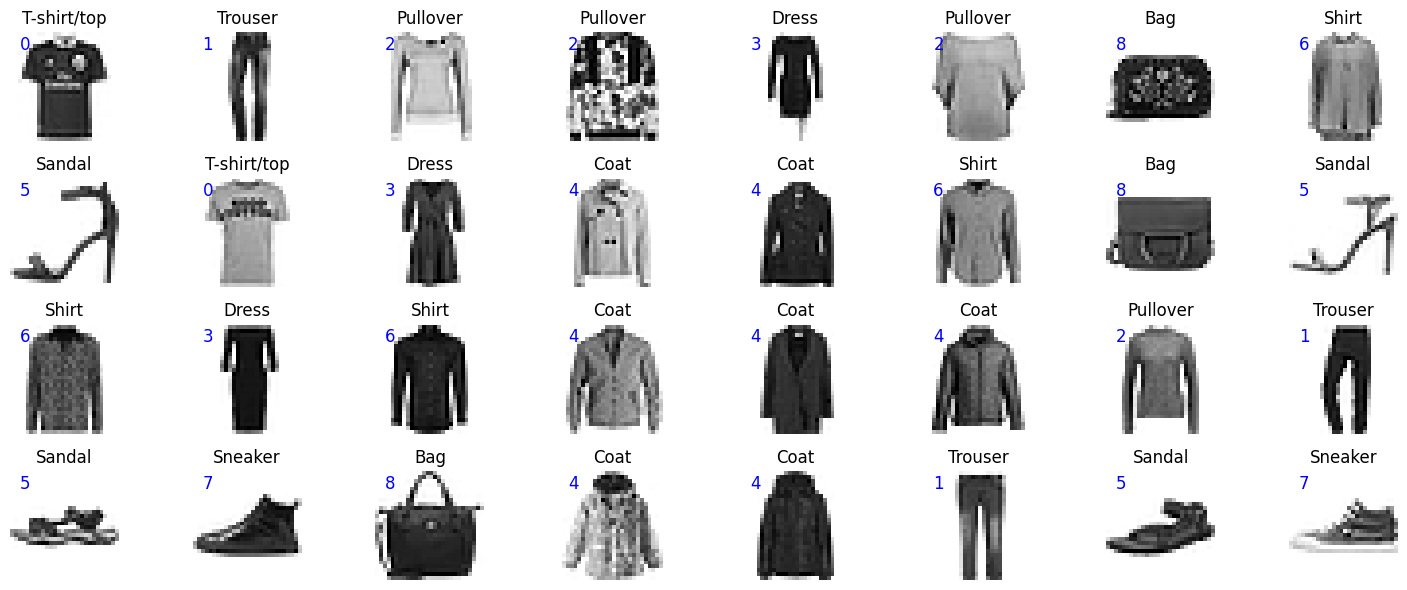

2024-07-25 18:08:35.866070: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [13]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Create the convolutional base

<img src = '../../images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

## Model with Dropout

In [14]:
dor1 = 0.1 # drop out rates
dor2 = 0.2 # drop out rates
dor3 = 0.35 # drop out rates

# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

# define input shape
input_shape = (28, 28, 1)

# create a sequential model
model = tf.keras.models.Sequential()

# create input layer
model.add(tf.keras.layers.Input(shape=input_shape))

# rescale to values between [0, 1.0]
model.add(tf.keras.layers.Rescaling(1./255),)

#############
### Set 01 ##
#############
# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu')) # (28 x 28 x 32)

# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (14 x 14 x 32)

# Dropout 1 - Drop out rate dor1
model.add(tf.keras.layers.Dropout(rate = dor1, 
                                  seed=RANDOM_STATE))

#############
### Set 02 ##
#############

# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu')) # (12 x 12 x 64)

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 6 x 6 x 64)

# Dropout 2 - Drop out rate dor1
model.add(tf.keras.layers.Dropout(rate = dor1, 
                                  seed=RANDOM_STATE))


#############
### Set 03 ##
#############

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 4 x 4 128)

In [15]:
model.add(tf.keras.layers.Flatten())

# Dropout 3 - Drop out rate dor2
model.add(tf.keras.layers.Dropout(rate = dor3, 
                                  seed=RANDOM_STATE))


# Dense 1
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dropout 4
model.add(tf.keras.layers.Dropout(rate = dor3, seed=RANDOM_STATE))

# Dense 2
model.add(tf.keras.layers.Dense(10))

## Define Call backs

In [16]:
checkpoint_filepath = os.path.join(modelDir, subDir, f'{altName}.keras')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_loss',
    mode = 'auto',
    save_best_only = True,
    verbose = 1
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True,
    verbose = 1)


### Compile and train the model

In [17]:
model.compile(optimizer='adam',              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),              
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=test_ds,epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks = [early_stopping_callback, model_checkpoint_callback])

Epoch 1/50


I0000 00:00:1721911117.071281   23015 service.cc:146] XLA service 0x7e7d0c00e120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721911117.071355   23015 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-25 18:08:37.098322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 18:08:37.255509: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  88/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3330 - loss: 1.8390

I0000 00:00:1721911119.920673   23015 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7110 - loss: 0.8043
Epoch 1: val_loss improved from inf to 0.34450, saving model to ../models/fashion_mnist/dropout_after_MaxPool.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7124 - loss: 0.8004 - val_accuracy: 0.8774 - val_loss: 0.3445
Epoch 2/50
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8628 - loss: 0.3837
Epoch 2: val_loss improved from 0.34450 to 0.29806, saving model to ../models/fashion_mnist/dropout_after_MaxPool.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8628 - loss: 0.3836 - val_accuracy: 0.8908 - val_loss: 0.2981
Epoch 3/50
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8824 - loss: 0.3253
Epoch 3: val_loss improved from 0.29806 to 0.25798, saving model to ../models/fashion_mnist/dropout_after_MaxPool.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8824 - loss: 0.3253 - val_accuracy: 0.9054 - val_loss: 0.2580
Epoch 4/50
1861/1875 ━━━━━━━━━━━━━

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,376 (2.57 MB)

 Trainable params: 224,458 (876.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 448,918 (1.71 MB)

In [19]:
res_df = pd.DataFrame(history.history)
res_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.796100,0.569168,0.8774,0.344500
1,0.868683,0.368846,0.8908,0.298061
2,0.885133,0.319674,0.9054,0.257981
3,0.895017,0.291777,0.8970,0.272509
4,0.901617,0.275337,0.9115,0.241988


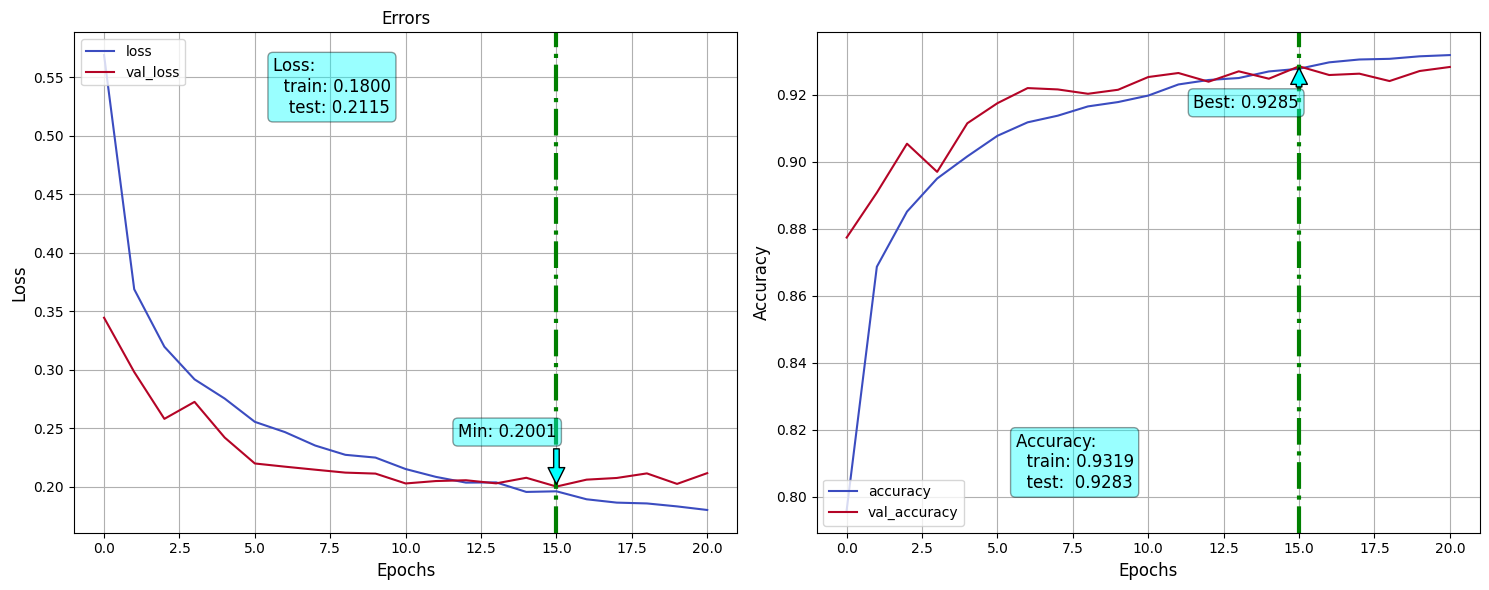

In [20]:
fn_plot_tf_hist(res_df) #0.1942, 0.9300

### Notes:
- Batch size is 32.
- Early stopping is used.
- In general, dropout is preferred **after** Maxpool layer. Max pool is extracting most significant feature and droup out is supressing a few. So maxpool may eliminate nodes supressed by dropout. 

### Evaluate the model

In [21]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

313/313 - 0s - 861us/step - accuracy: 0.9285 - loss: 0.2001


In [22]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [23]:
yhat = model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy score on Test Data : 0.9285


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.89      0.89      0.89      1000
           3       0.92      0.95      0.93      1000
           4       0.88      0.90      0.89      1000
           5       0.99      0.98      0.99      1000
           6       0.83      0.75      0.79      1000
           7       0.97      0.96      0.96      1000
           8       0.99      0.98      0.99      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



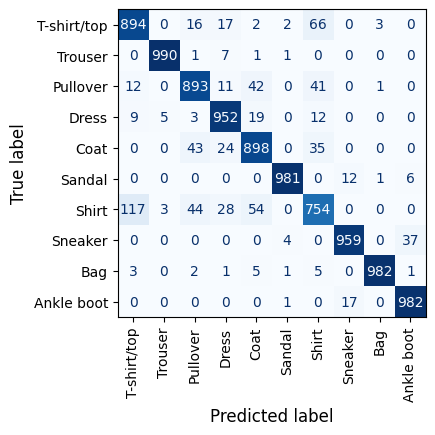

In [25]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)

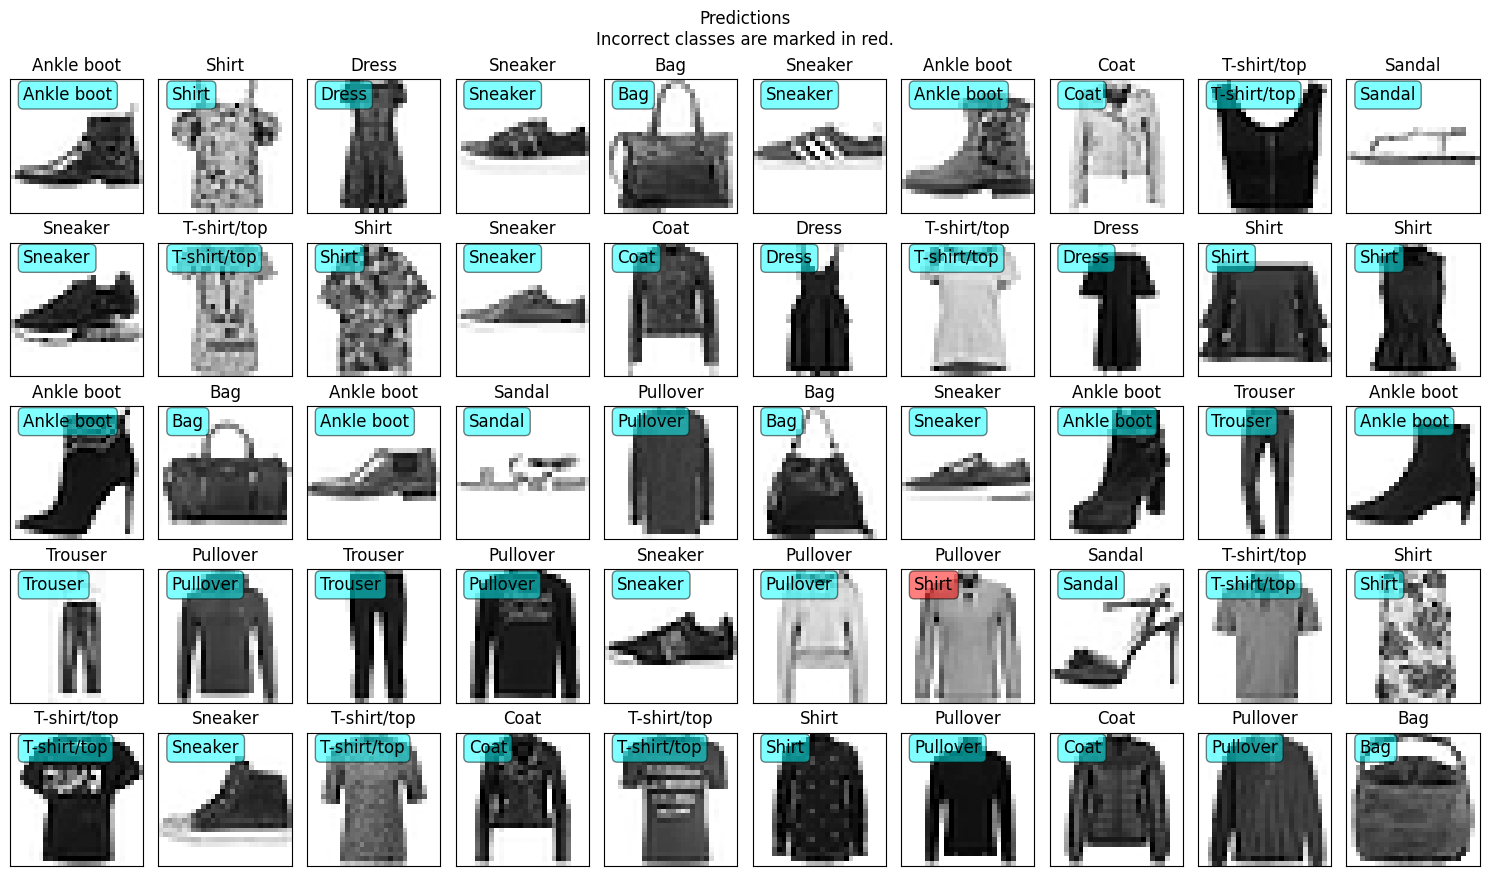

In [26]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

fntsize = 12

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_labels[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_labels[row.iloc[-1]], transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\nIncorrect classes are marked in red.')
plt.tight_layout()
plt.show()

In [27]:
new_model = tf.keras.models.load_model(os.path.join(modelDir, subDir, f'{altName}.keras'))

# Show the model architecture
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,376 (2.57 MB)

 Trainable params: 224,458 (876.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 448,918 (1.71 MB)

In [28]:
#Try running evaluate and predict with the loaded model:


# Evaluate the restored model
loss, acc = new_model.evaluate(test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 1s - 3ms/step - accuracy: 0.9285 - loss: 0.2001
Restored model, accuracy: 92.85%
